In [1]:
import os
import re

import anndata
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from umap import UMAP
from sklearn.preprocessing import StandardScaler


In [2]:
import torch
from torchvision import datasets, transforms

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import violet
from violet.utils.attention import plot_image_attention, get_image_attention
from violet.utils.model import predict, load_pretrained_model
from violet.utils.dataloaders import get_dataloader, listfiles, image_classification_dataloaders, prediction_dataloader
from violet.utils.analysis import plot_image_umap

In [22]:
img_dir = '/data/violet/sandbox/multiresolution_dino_tcia/normalized_input/label/'
weights = '/data/violet/sandbox/multiresolution_dino_tcia/dino_run/checkpoint.pth'

In [8]:
dl = prediction_dataloader(img_dir)

/home/estorrs/miniconda3/envs/violet/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [9]:
torch.cuda.set_device(3)
torch.cuda.current_device()

3

In [10]:
model = load_pretrained_model(weights, model_name='xcit_small', patch_size=8)
model = model.cuda()

Take key teacher in provided checkpoint dict
Pretrained weights found at /data/violet/sandbox/multiresolution_dino_tcia/dino_run/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [11]:
fps = sorted(listfiles(img_dir, regex='.jpeg$'))
len(fps)

6008

In [12]:
attn = get_image_attention(fps[0], model)
attn.shape

(16, 785)

(<Figure size 1296x288 with 48 Axes>,
 array([[<AxesSubplot:title={'center':'head 0'}, ylabel='overlay'>,
         <AxesSubplot:title={'center':'head 1'}>,
         <AxesSubplot:title={'center':'head 2'}>,
         <AxesSubplot:title={'center':'head 3'}>,
         <AxesSubplot:title={'center':'head 4'}>,
         <AxesSubplot:title={'center':'head 5'}>,
         <AxesSubplot:title={'center':'head 6'}>,
         <AxesSubplot:title={'center':'head 7'}>,
         <AxesSubplot:title={'center':'head 8'}>,
         <AxesSubplot:title={'center':'head 9'}>,
         <AxesSubplot:title={'center':'head 10'}>,
         <AxesSubplot:title={'center':'head 11'}>,
         <AxesSubplot:title={'center':'head 12'}>,
         <AxesSubplot:title={'center':'head 13'}>,
         <AxesSubplot:title={'center':'head 14'}>,
         <AxesSubplot:title={'center':'head 15'}>],
        [<AxesSubplot:ylabel='image'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubp

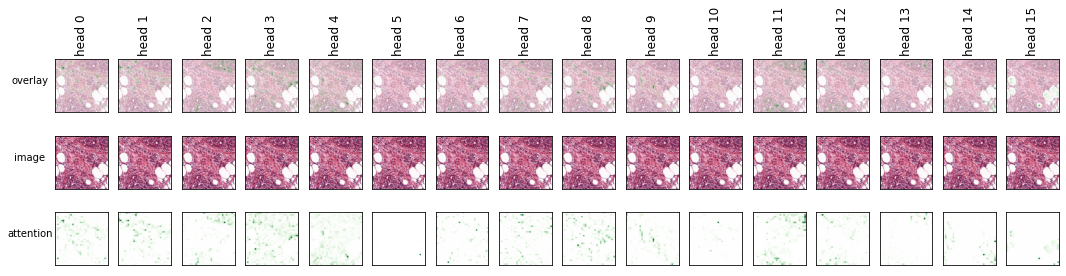

In [13]:
plot_image_attention(fps[50], model)

(<Figure size 1296x288 with 3 Axes>,
 array([<AxesSubplot:ylabel='overlay'>, <AxesSubplot:ylabel='image'>,
        <AxesSubplot:ylabel='attention'>], dtype=object))

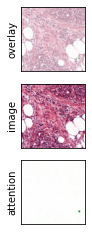

In [14]:
plot_image_attention(fps[50], model, display='mean')

(<Figure size 1296x288 with 48 Axes>,
 array([[<AxesSubplot:title={'center':'head 0'}, ylabel='overlay'>,
         <AxesSubplot:title={'center':'head 1'}>,
         <AxesSubplot:title={'center':'head 2'}>,
         <AxesSubplot:title={'center':'head 3'}>,
         <AxesSubplot:title={'center':'head 4'}>,
         <AxesSubplot:title={'center':'head 5'}>,
         <AxesSubplot:title={'center':'head 6'}>,
         <AxesSubplot:title={'center':'head 7'}>,
         <AxesSubplot:title={'center':'head 8'}>,
         <AxesSubplot:title={'center':'head 9'}>,
         <AxesSubplot:title={'center':'head 10'}>,
         <AxesSubplot:title={'center':'head 11'}>,
         <AxesSubplot:title={'center':'head 12'}>,
         <AxesSubplot:title={'center':'head 13'}>,
         <AxesSubplot:title={'center':'head 14'}>,
         <AxesSubplot:title={'center':'head 15'}>],
        [<AxesSubplot:ylabel='image'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubp

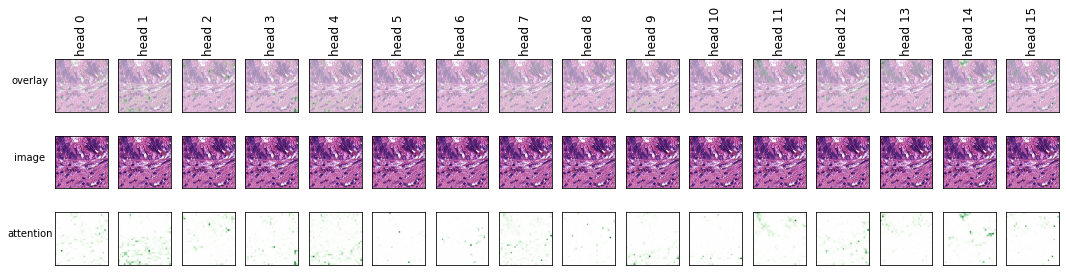

In [15]:
plot_image_attention('/home/estorrs/violet/sandbox/tmp/tumor_boundary_4.png', model)

In [ ]:
plot_image_attention('/home/estorrs/violet/sandbox/tmp/tumor_boundary_4.png', model, display='mean')

In [16]:
len(fps)

7174

In [ ]:
[x for x in fps if 'C3L-00017-21' in x]

In [19]:
samples = sorted({x.split('/')[-2] for x in fps})
samples

['C3L-00017-21',
 'C3L-00102-21',
 'C3L-00189-21',
 'C3L-00277-21',
 'C3L-00395-21',
 'C3L-00589-21',
 'C3L-00598-21',
 'C3L-00599-21',
 'C3L-00622-21',
 'C3L-00625-21',
 'C3L-00640-21',
 'C3L-00819-21',
 'C3L-00881-21',
 'C3L-00885-21',
 'C3L-00928-21',
 'C3L-01031-21',
 'C3L-01032-21',
 'C3L-01036-21',
 'C3L-01037-21',
 'C3L-01052-21']

In [20]:
keep = ['^.*' + s + '.*.jpeg$' for s in samples if '-21' in s]
keep

['^.*C3L-00017-21.*.jpeg$',
 '^.*C3L-00102-21.*.jpeg$',
 '^.*C3L-00189-21.*.jpeg$',
 '^.*C3L-00277-21.*.jpeg$',
 '^.*C3L-00395-21.*.jpeg$',
 '^.*C3L-00589-21.*.jpeg$',
 '^.*C3L-00598-21.*.jpeg$',
 '^.*C3L-00599-21.*.jpeg$',
 '^.*C3L-00622-21.*.jpeg$',
 '^.*C3L-00625-21.*.jpeg$',
 '^.*C3L-00640-21.*.jpeg$',
 '^.*C3L-00819-21.*.jpeg$',
 '^.*C3L-00881-21.*.jpeg$',
 '^.*C3L-00885-21.*.jpeg$',
 '^.*C3L-00928-21.*.jpeg$',
 '^.*C3L-01031-21.*.jpeg$',
 '^.*C3L-01032-21.*.jpeg$',
 '^.*C3L-01036-21.*.jpeg$',
 '^.*C3L-01037-21.*.jpeg$',
 '^.*C3L-01052-21.*.jpeg$']

In [20]:
# keep = ['^.*.jpeg$']

In [24]:
dataloader = prediction_dataloader(img_dir, batch_size=64)

In [25]:
len(dataloader.dataset.samples)

6016

In [26]:
# dataloader = get_dataloader(img_dir, batch_size=1024, shuffle=False)
embs = predict(dataloader, model, )
embs.shape

0 0
10 640
20 1280
30 1920
40 2560
50 3200
60 3840
70 4480
80 5120
90 5760


(6016, 384)

In [ ]:
# np.save('/home/estorrs/violet/sandbox/results/xcit_dino_tcia_pda/embs.npy', embs)

In [ ]:
# embs = np.load('/home/estorrs/violet/sandbox/results/xcit_dino_tcia_pda/embs.npy')

In [ ]:
# x = UMAP(n_components=2).fit_transform(embs)

In [27]:
dataloader.dataset.samples[:10]

array(['C3L-00102-26_0', 'C3L-00102-26_1', 'C3L-00102-26_10',
       'C3L-00102-26_100', 'C3L-00102-26_101', 'C3L-00102-26_102',
       'C3L-00102-26_103', 'C3L-00102-26_104', 'C3L-00102-26_105',
       'C3L-00102-26_106'], dtype='<U17')

In [28]:
adata = anndata.AnnData(X=embs)

# for svs
adata.obs.index = dataloader.dataset.samples
adata.obs['sample'] = ['_'.join(s.split('_')[:-2]) for s in adata.obs.index]

# # for st
# adata.obs.index = [s.split('/')[-1].split('.')[0] for s, _ in dataloader.dataset.samples]
# adata.obs['sample'] = ['_'.join(s.split('_')[:-1]) for s in adata.obs.index]

adata

AnnData object with n_obs × n_vars = 6016 × 384
    obs: 'sample'

In [29]:
# adata.write_h5ad('/home/estorrs/violet/sandbox/results/xcit_dino_tcia_pda_normalized/emb_adata.h5ad')

In [30]:
# adata = sc.read_h5adad('/home/estorrs/violet/sandbox/results/xcit_dino_tcia_pda_normalized/emb_adata.h5ad')

In [31]:
idxs = np.random.permutation(np.arange(adata.shape[0]))[:10000]
x_train = adata.X[idxs]
x_train.shape

(6016, 384)

In [32]:
u = UMAP(n_components=2)
u.fit(x_train)

UMAP(dens_frac=0.0, dens_lambda=0.0)

In [33]:
adata.obsm['X_umap_emb'] = u.transform(adata.X)

In [34]:
from pathlib import Path
out = '/home/estorrs/violet/sandbox/results/pdac_ffpe_tcia_raw_augmented_20samples'
Path(out).mkdir(parents=True, exist_ok=True)

In [35]:
adata.write_h5ad(os.path.join(out, 'emb_adata.h5ad'))

... storing 'sample' as categorical


In [36]:
np.random.choice(adata.obs.index, replace=False, size=10000)

array(['C3L-00598-21_122_166', 'C3L-00598-21_158_156',
       'C3L-01031-21_100_140', ..., 'C3L-01037-21_62_108',
       'C3L-00885-21_70_72', 'C3L-01052-21_151_105'], dtype=object)

/home/estorrs/miniconda3/envs/violet/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


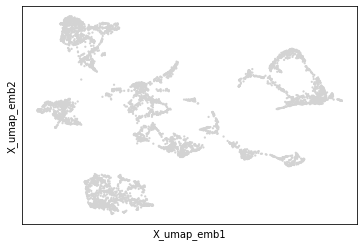

In [35]:
sc.pl.embedding(adata[np.random.choice(np.arange(adata.shape[0]), replace=False,
                                       size=min(10000, adata.shape[0]))], basis='X_umap_emb')

In [36]:
adata.obs['slide'] = [x.split('_')[0] for x in adata.obs.index]

In [37]:
len(sorted(set(adata.obs['slide'])))

12

In [39]:
samples = sorted(set(adata.obs['slide']))
samples = np.random.choice(samples, replace=False, size=min(20, len(set(adata.obs['slide']))))
f = adata[[True if s in samples else False for s in adata.obs['slide']]]
samples

array(['C3N-00511-22', 'C3N-01012-27', 'C3L-02899-26', 'C3L-01158-21',
       'C3N-00518-25', 'C3N-02573-21', 'C3L-00102-26', 'C3L-03628-29',
       'C3N-01382-22', 'C3N-01375-22', '<pad', 'C3L-01662-23'],
      dtype='<U12')

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'slide' as categorical


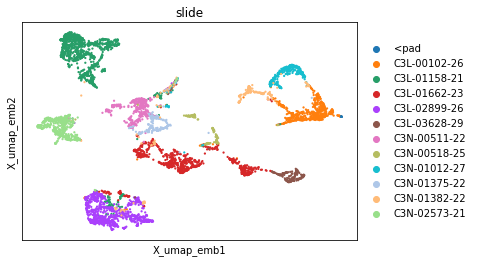

In [40]:

sc.pl.embedding(f, basis='X_umap_emb', color=['slide'])

In [41]:
fps = listfiles(img_dir, regex='.jpeg$')
sample_to_fp = {fp.split('/')[-1].split('.')[0]:fp for fp in fps}

In [43]:
sample_to_fp.keys()

dict_keys(['C3N-01382-22_27', 'C3L-02899-26_842', 'C3L-02899-26_499', 'C3L-01158-21_613', 'C3L-01158-21_956', 'C3N-00511-22_126', 'C3L-02899-26_92', 'C3L-01158-21_458', 'C3N-00511-22_424', 'C3L-01662-23_508', 'C3L-01158-21_6', 'C3L-01158-21_873', 'C3L-01158-21_982', 'C3L-00102-26_110', 'C3N-01012-27_236', 'C3L-01662-23_155', 'C3N-02573-21_495', 'C3N-01012-27_114', 'C3N-01012-27_110', 'C3N-00511-22_156', 'C3L-01158-21_1105', 'C3N-02573-21_471', 'C3L-00102-26_327', 'C3N-01375-22_44', 'C3N-01382-22_225', 'C3L-02899-26_907', 'C3N-01382-22_178', 'C3L-01158-21_192', 'C3L-02899-26_750', 'C3L-01158-21_164', 'C3L-02899-26_255', 'C3N-01012-27_237', 'C3L-00102-26_55', 'C3N-02573-21_228', 'C3L-01662-23_590', 'C3L-01662-23_283', 'C3L-01158-21_604', 'C3N-02573-21_57', 'C3L-00102-26_475', 'C3L-02899-26_154', 'C3N-00511-22_442', 'C3L-01158-21_1019', 'C3N-01382-22_149', 'C3L-01662-23_700', 'C3L-02899-26_615', 'C3L-00102-26_27', 'C3L-01158-21_165', 'C3L-01158-21_24', 'C3L-00102-26_442', 'C3L-01662-23_91

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

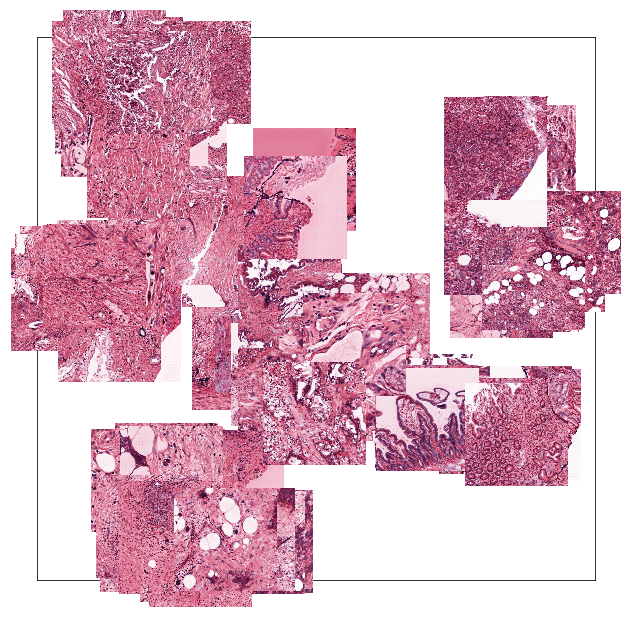

In [46]:
n = 100
idxs = np.random.permutation(f.obs.index.to_list())[:n]
filtered = f[idxs]
filtered = filtered[[True if 'pad' not in x else False for x in filtered.obs.index]]
plot_image_umap(
    filtered.obsm['X_umap_emb'][:, 0].flatten(),
    filtered.obsm['X_umap_emb'][:, 1].flatten(),
    [sample_to_fp[s] for s in filtered.obs.index]
)

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

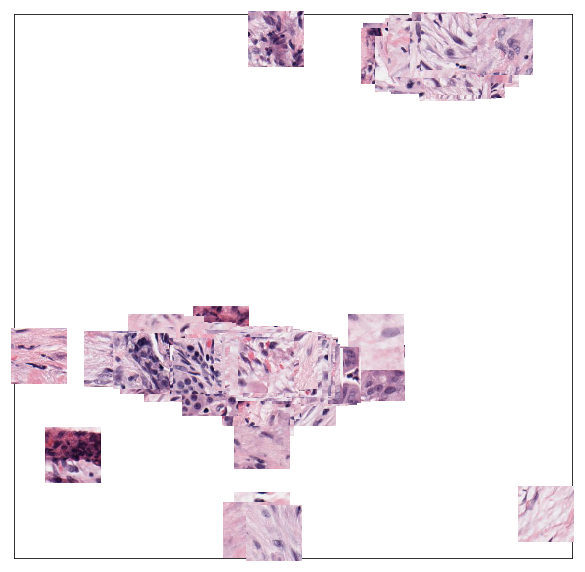

In [52]:
n = 2000
s = 'C3L-00189-21'
idxs = np.random.permutation([x for x in f.obs.index.to_list()
                              if s in x])[:n]
filtered = f[idxs]
plot_image_umap(
    filtered.obsm['X_umap_emb'][:, 0].flatten(),
    filtered.obsm['X_umap_emb'][:, 1].flatten(),
    [sample_to_fp[s] for s in filtered.obs.index],
    zoom=.5,
)

In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['figure.dpi'] = 300

In [48]:
from violet.utils.preprocessing import normalize_counts, get_svs_tile_shape, get_svs_array
scale = .1

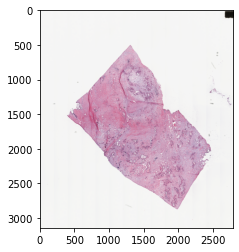

In [49]:
s = 'C3L-00277-21'
img = get_svs_array(f'/data/tcia/PDA/{s}.svs', scale=scale)
plt.imshow(img)

In [ ]:
s = 'C3L-01124-21'
img = get_svs_array(f'/data/tcia/PDA/{s}.svs', scale=scale)
plt.imshow(img)

In [ ]:
s = 'C3L-01662-23'
img = get_svs_array(f'/data/tcia/PDA/{s}.svs', scale=scale)
plt.imshow(img)

In [ ]:
adata

In [ ]:
import hdbscan
from collections import Counter
from hdbscan import approximate_predict
# idxs = np.random.permutation(np.arange(adata.shape[0]))[:10000]

# clf = hdbscan.HDBSCAN(
#     min_samples=1,
#     min_cluster_size=100,
#     prediction_data=True,
# #     cluster_selection_epsilon=.1,
# )
# clf.fit(adata.obsm['X_umap_emb'][idxs])
# labels = approximate_predict(clf, adata.obsm['X_umap_emb'][idxs])
# sorted(set(labels[0])), Counter(labels[0])[-1]
# labels = clf.predict(adata.obsm['X_umap_emb'])

In [ ]:
from sklearn.cluster import KMeans
idxs = np.random.permutation(np.arange(adata.shape[0]))[:10000]
n_clusters = 15
clf = KMeans(n_clusters=n_clusters)
# clf.fit(adata.obsm['X_umap_emb'][idxs])
# labels = clf.predict(adata.obsm['X_umap_emb'])
clf.fit(adata.X[idxs])
labels = clf.predict(adata.X)
Counter(labels).most_common()

In [ ]:
adata.obs['cluster'] = [str(x) for x in labels]

In [ ]:
f = adata[[True if s in samples else False for s in adata.obs['slide']]]
f.shape

In [ ]:

sc.pl.embedding(f, basis='X_umap_emb', color=['slide'])

In [ ]:

sc.pl.embedding(f, basis='X_umap_emb', color=['cluster'])

In [ ]:
adata.obs['case_id'] = ['-'.join(x.split('-')[:2]) for x in adata.obs['slide']]
adata.obs

In [ ]:
case_to_proportions = {}
clusters = sorted(set(adata.obs['cluster']))
for case in sorted(set(adata.obs['case_id'])):
    case_to_proportions[case] = {}
    filtered = adata[adata.obs['case_id']==case]
    counts = Counter(filtered.obs['cluster'])
    for c in clusters:
        case_to_proportions[case][c] = counts[c] / filtered.shape[0]
        

In [ ]:
case_to_proportions

In [ ]:
pd.DataFrame.from_dict(case_to_proportions)

In [ ]:
clinical = pd.read_csv('/data/tcia/clinical/PDA_cleaned.txt', sep='\t')
clinical

In [ ]:
set(clinical['case_id']).intersection(set(case_to_proportions.keys()))

In [ ]:
case_to_proportions['C3L-00881']

In [ ]:
for c in clusters:
    clinical[c] = [case_to_proportions[x][c] if x in case_to_proportions else np.nan for x in clinical['case_id']]
clinical

In [ ]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

In [ ]:
source = clinical.iloc[:, 2:]
source.index = clinical['case_id']
source['status'] = [x - 1 for x in source['status']]
source = source[~np.any(pd.isnull(clinical).values, axis=1)]
source

In [ ]:
source.columns[2:].to_list()

In [ ]:
a = anndata.AnnData(X=source.iloc[:, 2:].values, obs=source.iloc[:, :2])
a.var.index = source.columns[2:].to_list()
a

In [ ]:
sc.pp.neighbors(a)
sc.tl.umap(a)
sc.tl.leiden(a)
a

In [ ]:
sc.pl.umap(a, color=['leiden'])

In [ ]:
sc.pl.umap(a, color=a.var.index.to_list())

In [ ]:
kmf = KaplanMeierFitter()

ft = ft[~pd.isnull(ft['classification'])]
T = ft['survival_time']
E = ft['status']
groups = ft[f'classification']

for cluster in sorted(set(ft['classification'])): 
    kmf.fit(T[groups==cluster], E[groups==cluster], label=cluster)
    ax = kmf.plot(show_censors=True, ci_show=False, )

In [ ]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

for cluster in sorted(set(a.obs['leiden'])): 
    df = a[a.obs['leiden']==cluster].obs
    kmf.fit(df['survival_time'], event_observed=df['status']==1, label=cluster)
    ax = kmf.plot(show_censors=True, ci_show=False, )

In [ ]:
f.obs['highlight'] = ['0' if x in ['12', '13'] else '1' for x in f.obs['cluster']]
sc.pl.embedding(f, basis='X_umap_emb', color=['highlight', 'slide'])

In [ ]:
sc.pl.embedding(f, basis='X_umap_emb', color=['cluster'])

In [ ]:
a[a.obs['leiden']=='3'].obs

In [ ]:
s = 'C3L-00599-21'
img = get_svs_array(f'/data/tcia/PDA/{s}.svs', scale=scale)
plt.imshow(img)

In [ ]:
s = 'C3L-00625-21'
img = get_svs_array(f'/data/tcia/PDA/{s}.svs', scale=scale)
plt.imshow(img)

In [ ]:
df = adata[adata.obs['slide']=='C3L-00599-21'].obs
df

In [ ]:
from matplotlib import cm
from violet.utils.analysis import display_predictions, display_2d_scatter
df = adata[adata.obs['slide']=='C3L-00599-21'].obs
df['cluster'] = [str(x) for x in df['cluster']]
display_2d_scatter(df, 'cluster', cmap='tab10', legend=True)

In [ ]:
a.obs['slide'] = [x + '-21' for x in a.obs.index]

In [ ]:
for s in a[a.obs['leiden']=='3'].obs['slide']:
    print(s)
    df = adata[adata.obs['slide']==s].obs
    df['cluster'] = [str(x) for x in df['cluster']]
    display_2d_scatter(df, 'cluster', cmap='tab20', legend=True)
    plt.show()

In [ ]:
s = 'C3L-03129-21'
img = get_svs_array(f'/data/tcia/PDA/{s}.svs', scale=scale)
plt.imshow(img)

In [ ]:
from scipy.stats import spearmanr
import seaborn as sns

In [ ]:
for i in sorted(set(adata.obs['cluster'])):
    xs, ys = zip(*[(x, y) for x, y in zip(source['survival_time'], source[i])])
    corr, p = spearmanr(xs, ys, )
    print(i, corr, p)
    df = pd.DataFrame.from_dict({'survival': xs, 'fraction': ys})
    sns.regplot(data=df, x='survival', y='fraction')
    plt.show()

In [ ]:
sc.pp.neighbors(adata)

In [ ]:
umap_X = UMAP().fit_transform(source.iloc[:, 4:])
source['UMAP1'], source['UMAP2'] = umap_X[:, 0], umap_X[:, 1]
plt.scatter(umap_X[:, 0], umap_X[:, 1])

In [ ]:
labels = KMeans(n_clusters=5).fit_predict(source[['UMAP1', 'UMAP2']])
source['classification'] = [str(x) for x in labels]
source

In [ ]:
source[source['classification']=='4']

In [ ]:
sns.scatterplot(data=source, x='UMAP1', y='UMAP2', hue='classification', hue_order=['0', '1', '2', '3', '4'])

In [ ]:
sns.scatterplot(data=source, x='UMAP1', y='UMAP2', hue='9', hue_order=['0', '1', '2', '3', '4'])

In [ ]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
# ft = integrated.obs.copy()
ft = source
ft = ft[~pd.isnull(ft['classification'])]
T = ft['survival_time']
E = ft['status']
groups = ft[f'classification']

for cluster in sorted(set(ft['classification'])): 
    kmf.fit(T[groups==cluster], E[groups==cluster], label=cluster)
    ax = kmf.plot(show_censors=True, ci_show=False, )

In [ ]:
cols = [str(x) for x in range(15)]
cols += ['classification']
source[cols]

In [ ]:
source[cols].groupby('classification').mean()

In [ ]:
adata.obs

In [ ]:
s2i = {}
for i, (fp, _) in enumerate(dataloader.dataset.imgs):
    s = fp.split('/')[-1].split('.')[0]
    s2i[s] = fp
    
# dataloader.dataset.imgs

In [ ]:
from einops import rearrange

In [ ]:
idxs = np.random.choice(adata[adata.obs['cluster']=='9'].obs.index, size=10)
for i in idxs:
    img = default_loader(s2i[i])
    plt.imshow(img)
    plt.show()

In [ ]:
from torchvision.datasets.folder import default_loader

In [ ]:
len(set(adata.obs.index))

In [ ]:
adata.obs.shape

In [ ]:
n = 1000
idxs = np.random.permutation(adata[adata.obs['cluster']=='9'].obs.index.to_list())[:n]
pool = set(idxs)
idxs = [i for i, x in enumerate(adata.obs.index) if x in pool]
filtered = adata.obs.iloc[idxs]
# filtered
plot_image_umap(
    adata.obsm['X_umap_emb'][idxs, 0].flatten(),
    adata.obsm['X_umap_emb'][idxs, 1].flatten(),
    [s2i[s] for s in filtered.index]
)

In [ ]:
# merge


In [ ]:
kmf = KaplanMeierFitter()
# ft = integrated.obs.copy()
ft = p
ft = ft[~pd.isnull(ft['classification'])]
T = ft['survival_time']
E = ft['status']
groups = ft[f'classification']

for cluster in sorted(set(ft['classification'])): 
    kmf.fit(T[groups==cluster], E[groups==cluster], label=cluster)
    ax = kmf.plot(show_censors=True, ci_show=False, )

In [ ]:
s = 'C3L-00017-21'
a = adata[adata.obs['slide']==s].copy()
# sc.pp.neighbors(a)
# sc.tl.umap(a)
# sc.tl.leiden(a)
# a

In [ ]:
adata.obs

In [ ]:
a

In [ ]:
from violet.utils.analysis import display_2d_scatter
import matplotlib.pyplot as plt
display_2d_scatter(a.obs, 'cluster', hue_order=sorted(set(a.obs['cluster'])))
plt.tight_layout()

In [ ]:
from violet.utils.preprocessing import normalize_counts, get_svs_tile_shape, get_svs_array
scale = .1
res = 55.
img = get_svs_array(f'/data/tcia/PDA/{s}.svs', scale=scale)
img.shape

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.imshow(img)

In [ ]:
fmap = pd.read_csv('/home/estorrs/spatial-analysis/data/sample_map.txt', sep='\t', index_col=0)
fmap

In [ ]:
fmap = fmap[fmap['tissue_type']=='ffpe']

In [ ]:
from collections import Counter
counts = Counter(fmap['disease'])
xs, ys = zip(*counts.items())
pd.DataFrame.from_dict({'disease': xs, 'sample count': ys}).set_index('disease')

In [ ]:
adata.obs['disease'] = [fmap.loc[x, 'disease'] for x in adata.obs['sample']]
sc.pl.embedding(adata, basis='X_umap_emb', color=['disease'])

In [ ]:
# lets do co_met
keep = ['pdac']
co = adata[[True if x in keep else False for x in adata.obs['disease']]].copy()
co

In [ ]:
var = sc.read_visium(fmap.iloc[0]['spaceranger_output']).var
var

In [ ]:
obs = None
var = None
data = None
for i, row in fmap.iterrows():
    if row['disease'] in keep:
        a = sc.read_visium(row['spaceranger_output'])
        a.var_names_make_unique()
        a.var["mt"] = a.var_names.str.startswith("MT-")
        sc.pp.calculate_qc_metrics(a, qc_vars=["mt"], inplace=True)
        
        a.obs.index = [f'{i}_{x}' for x in a.obs.index]
        a.obs['sample'] = i
        
        if obs is None:
            obs = a.obs
        else:
            obs = pd.concat((obs, a.obs), axis=0)
            
        if var is None:
            var = a.var

        if data is None:
            data = a.X.toarray()
        else:
            data = np.concatenate((data, a.X.toarray()), axis=0)
obs.shape, var.shape, data.shape

In [ ]:
adata_exp = anndata.AnnData(X=data)
adata_exp.var = var
adata_exp.obs = obs
adata_exp

In [ ]:
sns.histplot(adata_exp.obs, x='total_counts', kde=False, hue='sample')

In [ ]:
exclude_samples = ['HT213C1A4_U1', 'HT165C1A3', 'HT250C1', 'HT253C1T1']
adata_exp = adata_exp[[True if s not in exclude_samples else False
                      for s in adata_exp.obs['sample']]]

In [ ]:
sc.pp.filter_cells(adata_exp, min_counts=1000)

sc.pp.normalize_total(adata_exp, inplace=True)
sc.pp.log1p(adata_exp)
sc.pp.highly_variable_genes(adata_exp, flavor="seurat", n_top_genes=2000)

In [ ]:
for i, row in fmap.iterrows():
    if row['disease'] in keep:
        print(i)
        a = sc.read_visium(row['spaceranger_output'])
        a.var_names_make_unique()
        sc.pl.spatial(a)

In [ ]:
s_id = 'HT112C1_U2'
ref = co[co.obs['sample']==s_id].copy()
sc.pp.pca(ref)
sc.pp.neighbors(ref)
sc.tl.umap(ref)
sc.tl.leiden(ref)
new = []
for s in sorted(set(co.obs['sample'])):
    small = co[co.obs['sample']==s].copy()
    if s!=s_id:
        sc.tl.ingest(small, ref, obs=['leiden'])
        new.append(small)
new.append(ref)
corrected = anndata.concat(new)
corrected

In [ ]:
sc.pl.umap(corrected, color='leiden')

In [ ]:
overlap = sorted(set(corrected.obs.index).intersection(set(adata_exp.obs.index)))
corrected_exp = adata_exp[overlap]

In [ ]:
corrected_exp.obs['disease'] = [corrected.obs.loc[x, 'disease'] for x in corrected_exp.obs.index]
corrected_exp.obs['leiden'] = [corrected.obs.loc[x, 'leiden'] for x in corrected_exp.obs.index]
corrected_exp.obsm['X_umap'] = corrected[overlap].obsm['X_umap']
corrected_exp

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180

In [ ]:
sc.pl.umap(corrected, color=['sample', 'disease', 'leiden'], ncols=1, size=10)

In [ ]:
fps = listfiles(img_dir, regex='.jpeg$')
sample_to_fp = {fp.split('/')[-1].split('.')[0]:fp for fp in fps}

In [ ]:
n = 500
idxs = np.random.permutation(corrected_exp.obs.index.to_list())[:n]
filtered = corrected_exp[idxs]
plot_image_umap(
    filtered.obsm['X_umap'][:, 0].flatten(),
    filtered.obsm['X_umap'][:, 1].flatten(),
    [sample_to_fp[s] for s in filtered.obs.index]
)

In [ ]:
genes = ['leiden', 'CD3G', 'IL7R', 'CD8A']
sc.pl.umap(corrected_exp, color=genes, size=10)

In [ ]:
genes = ['leiden', 'EPCAM', 'CDH1']
sc.pl.umap(corrected_exp, color=genes, size=10)

In [ ]:
# visualize
s_id = 'HT112C1_U2'
a = sc.read_visium(fmap.loc[s_id, 'spaceranger_output'])
a.var_names_make_unique()
a.obs.index = [f'{s_id}_{x}' for x in a.obs.index]
sc.pp.normalize_total(a, inplace=True)
sc.pp.log1p(a)
sc.pp.highly_variable_genes(a, flavor="seurat", n_top_genes=2000)
a

In [ ]:
a.obs['leiden'] = [corrected.obs.loc[x, 'leiden'] for x in a.obs.index]
a.obsm['X_umap'] = corrected[a.obs.index].obsm['X_umap'].copy()

In [ ]:
sc.pl.spatial(a, color='leiden')

In [ ]:
sc.pl.spatial(a)

In [ ]:
genes = ['leiden', 'CD3G', 'IL7R', 'CD8A']
sc.pl.spatial(a, color=genes)

In [ ]:
genes = ['leiden', 'EPCAM', 'CDH1']
sc.pl.spatial(a, color=genes)

In [ ]:
genes = ['leiden', 'CD3G', 'IL7R', 'CD8A']
sc.pl.umap(a, color=genes)

In [ ]:
genes = ['leiden', 'EPCAM', 'CDH1']
sc.pl.umap(a, color=genes)

In [ ]:
genes = ['leiden', 'AFP']
sc.pl.umap(a, color=genes)

In [ ]:
# grab some tumor cells and plot attention
ts1 = np.random.permutation(a[a.obs['leiden']=='0'].obs.index)[:5]
for s in ts1:
    print(s)
    plot_image_attention(sample_to_fp[s], model)
    plt.show()

In [ ]:
for s in ts1:
    print(s)
    plot_image_attention(sample_to_fp[s], model, overlay_only=True)
    plt.show()

In [ ]:
ts2 = np.random.permutation(a[a.obs['leiden']=='1'].obs.index)[:5]

for s in ts2:
    print(s)
    plot_image_attention(sample_to_fp[s], model, overlay_only=True)
    plt.show()

In [ ]:
ts2 = np.random.permutation(a[a.obs['leiden']=='9'].obs.index)[:5]

for s in ts2:
    print(s)
    plot_image_attention(sample_to_fp[s], model, overlay_only=True)
    plt.show()

In [ ]:
ts2 = np.random.permutation(a[a.obs['leiden']=='2'].obs.index)[:5]

for s in ts2:
    print(s)
    plot_image_attention(sample_to_fp[s], model, overlay_only=True)
    plt.show()

In [ ]:
roi_fp = '/home/estorrs/sandbox/co_immune_tumor_roi.png'
plot_image_attention(roi_fp, model, overlay_only=False)

In [ ]:
roi_fp = '/home/estorrs/sandbox/co_immune_tumor_roi2.png'
plot_image_attention(roi_fp, model, overlay_only=False)

In [ ]:
roi_fp = '/home/estorrs/sandbox/co_immune_tumor_roi3.png'
plot_image_attention(roi_fp, model, overlay_only=False)

In [ ]:
roi_fp = '/home/estorrs/sandbox/co_immune_tumor_roi4.png'
plot_image_attention(roi_fp, model, overlay_only=False)

In [ ]:
p = [[x*255 for x in pal] for pal in sns.color_palette()]

In [ ]:
p

In [ ]:
p